5.275331301848058e-14 8.780918340309727e-11


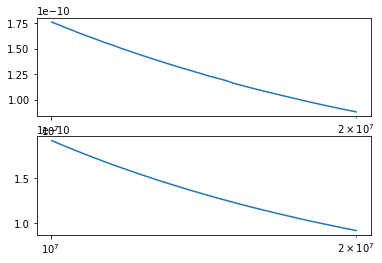

In [6]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import os
import matplotlib.pyplot as plt

filepath0 = 'D:\\Nutstore\\PhD\\Experiment\\Cooperation Uni-Chongqing\\20190415 -impedance\\kongqi\\AIR1.CSV'
filepath1 = 'D:\\Nutstore\\PhD\\Experiment\\Cooperation Uni-Chongqing\\20190415 -impedance\\chunshui\\PURE WATER1.CSV'
rfl = 1e7
rfh = 1e8

def data_Re_Im(EIS):
    '''
    将原始数据的|Z|和相位角转化为实部和虚部电容，并且按实部虚部排列
    '''
    col_n = EIS.shape[1]
    col_m = EIS.shape[0]
    Data_EIS = np.zeros(col_m*col_n).reshape(col_m,col_n)
    Data_EIS[:,0]=EIS[:,0]
    wr = 2*np.pi*Data_EIS[:,0]
    Data_EIS[:,1] = EIS[:,1]*(np.cos(EIS[:,2]*np.pi/180)) # 实部,注意三角函数计算的不是度数，所以需要转化
    Data_EIS[:,2] = EIS[:,1]*(np.sin(EIS[:,2]*np.pi/180)) # 虚部
    Data_EIS[:,2] = -1/(EIS[:,2]*wr)
    return Data_EIS

def read_file(filepath,n,m):
    EIS = pd.read_csv(filepath,header=n,nrows=m,usecols=[0,1,2])
    EIS.columns = (['Frequency','Data_Real','Data_Image'])
    EIS = EIS.loc[(EIS.Frequency>=rfl)&(EIS.Frequency<=rfh)]
    EIS = EIS.values
    return EIS

Z_0 = read_file(filepath0,n=3,m=701)
Z_1 = read_file(filepath1,n=4,m=701)

Z_air = data_Re_Im(Z_0)
Z_water = data_Re_Im(Z_1)

plt.subplot(211)
plt.semilogx(Z_air[:,0],Z_air[:,2])
plt.subplot(212)
plt.semilogx(Z_water[:,0],Z_water[:,2])

rc = np.zeros(Z_water.shape[0]*2).reshape(Z_water.shape[0],2)

for k in range(Z_water.shape[0]):
    
    def func(i):
        x,y =i[0],i[1]
        return [x + y - Z_air[k,2],
                         78*x + y - Z_water[k,2]]
    r1,r2 = fsolve(func,[0,0])
    rc[k,0] = r1
    rc[k,1] = r2
rc = pd.DataFrame(rc,columns=['c0','cf'])
nrc = 35
c0,cf = rc['c0'][nrc], rc['cf'][nrc]
print(c0,cf)

K:       6.527418e-06 
 alpha_EP: 7.887671e-01 
 
 eh        2.012280e-03 
 el        2.258516e+04 
 tau       9.069241e-07 
 a         9.238764e-01 
 kdc       3.872336e-01 
 cf        3.872336e-01 



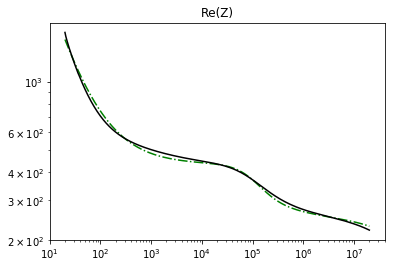

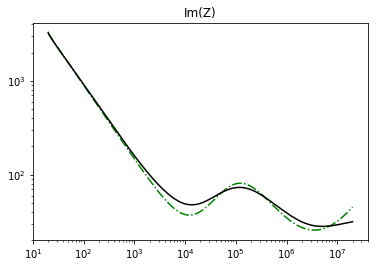

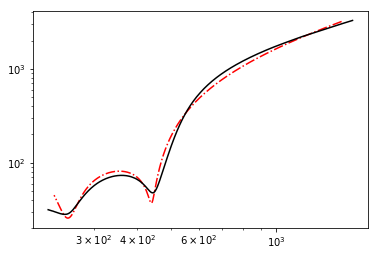

Goodness of Fit:  0.9994102456014069
end


In [29]:
#_*_coding:utf-8_*_
# package of sopt: https://www.cnblogs.com/lyrichu/p/9163203.html
# author: Fukun Shi
# 2019/03/24
'''First step, exclude the electrode polarization.'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants as c
from scipy.optimize import curve_fit
from time import time
import copy

fl = 1e1
fh = 1e8   # higher frequency may include stray capacitance and inductance

filepath = 'D:\\Nutstore\\PhD\\Experiment\\Cooperation Uni-Chongqing\\MCF-7_Im_Re_mean.xlsx'
EIS = pd.read_excel(filepath)
EIS = EIS.loc[(EIS.Frequency>=fl)&(EIS.Frequency<=fh)]
EIS = EIS.values
f = EIS[:,0]
w = 2*np.pi*f
point = len(w)

z = EIS[:,1] + 1j*EIS[:,2]
y = 1/z
Y = np.concatenate((z.real,z.imag))

e0 = c.epsilon_0

length = 5e-3    # length of electrodes unit(m)
width = 1.6e-3   # width of electrodes
S = length*width # area of electrodes
gap = 2e-3       # gap between electrodes
a = S/gap
#c0 = 2.41974648880026e-13#a*e0        # rc['c0'][rci] #capacitance of air, the electrode is a parallel capacitor
#cf = 4.42532194241202e-12#4e-12     # stray capacitance

def Z_fit(w,K,alpha_EP,eh,el,tau,a,kdc,cf):
    esus0 = eh + (el-eh)/(1+(1j*w*tau)**a)                          # permittivity for suspension cells
    Ys = 1j*(esus0)*w*c0 + 1j*w*cf + kdc*c0/e0                # cell suspension admittance spectrum
    Zs = 1/Ys
    Z_EP = K**(-1)*(1j*w)**(-alpha_EP)#R0ep/(1+(1j*w*tauep)**alphaep)
    
    Z = Z_EP + Zs
    Z_fit = np.hstack([Z.real,Z.imag])
    return Z_fit
K,alpha_EP = 1e-5,0.5
eh,el, tau, a, kdc = 2e1,2e3,1e-6,0.9,7e-2
cf = 1e-12
p0 = np.array([K,alpha_EP,eh,el,tau,a,kdc,cf])#np.array([1e6,0.8,1e-1,1,1e5,1e-5,0.6,0.5])
bounds = (0,[1e-4,1,1e2,1e6,1e-3,1,1,1e-9])
popt,pcov = curve_fit(Z_fit,w,Y,p0=p0,maxfev=1000000,ftol=1e-12)

#print(popt)

print('K:      ','%e'%popt[0],'\n',
     'alpha_EP:','%e'%popt[1],'\n',
     '\n',
     'eh       ','%e'%popt[2],'\n',
     'el       ','%e'%popt[3],'\n',
     'tau      ','%e'%popt[4],'\n',
     'a        ','%e'%popt[5],'\n',
     'kdc      ','%e'%popt[6],'\n',
     'cf       ','%e'%popt[6],'\n',
     )

point = len(w)
plt.loglog(f,Z_fit(w,*popt)[0:point],'g-.')
plt.loglog(f,EIS[:,1],'k')
plt.title('Re(Z)')
plt.show()

plt.loglog(f,-Z_fit(w,*popt)[point:],'g-.')
plt.loglog(f,-EIS[:,2],'k')
plt.title('Im(Z)')
plt.show()

plt.loglog(Z_fit(w,*popt)[0:point],-Z_fit(w,*popt)[point:],'r-.')
plt.loglog(EIS[:,1],-EIS[:,2],'k')
plt.show()

# residual sum of squares
ss_res = np.sum((Y - Z_fit(w,*popt)) ** 2)
# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print('Goodness of Fit: ',r2)

print('end')

In [26]:
K,alpha_EP = 1e-5, 0.5
eh,el, tau, a, kdc = 2e1, 2e3, 1e-6, 0.9, 7e-2
cf = 1e-12
p0 = np.array([K,alpha_EP,eh,el,tau,a,kdc,cf])
print(p0.shape)

(8,)


[1.20856346e+07 1.21124818e+07 1.32035451e-06 8.62541858e-01
 3.83672718e-01]


C:\Users\fukun\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


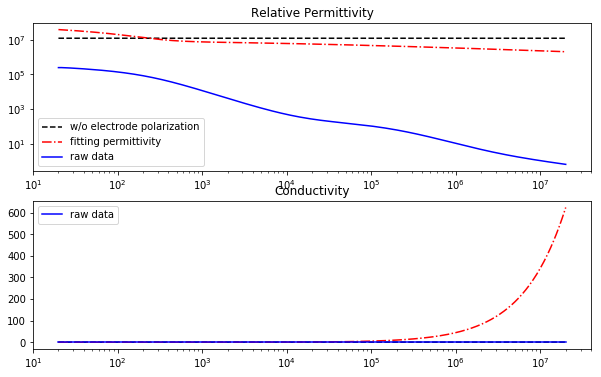

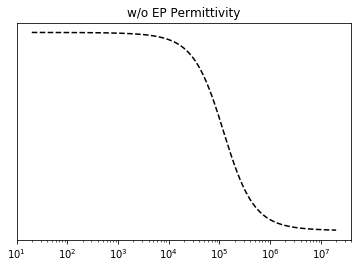

In [14]:
'''
Second step, verify if the fitting is correct or not  2019.04.14
'''
def e_Cole(w,Cole_para):
    '''去除电极极化的介电谱'''
    eh,el,tau,a,kdc = Cole_para

    esus0 = eh + (el-eh)/(1+(1j*w*tau)**a)
    #esus1 = 0#(el1)/(1+(1j*w*tau1)**a1)
    Y = 1j*(esus0)*w*c0 + 1j*w*cf + kdc*c0/e0 
    er = Y.imag/(w*c0) # equal to esus0.real
    ei = esus0.imag    # 对比这个Y.real/(w*a*e0)
    k_Cole = -ei*w*e0 + kdc
    Z_Cole = np.hstack([er,k_Cole])
    return Z_Cole

def epsilon_fit(w,C_para):
    '''拟合值的介电谱'''
    K,alpha_EP,eh,el,tau,a,kdc = C_para
    esus0 = eh + (el-eh)/(1+(1j*w*tau)**a)
    #esus1 = 0#(el1)/(1+(1j*w*tau1)**a1)
    Ys = 1j*(esus0)*w*c0 + 1j*w*cf + kdc*c0/e0                # cell suspension admittance spectrum
    Zs = 1/Ys
    Z_EP = K**(-1)*(1j*w)**(-alpha_EP)#R0ep/(1+(1j*w*tauep)**alphaep)
    
    Z = Z_EP + Zs
    Y = 1/Z
    epsilon_r = Y.imag/(w*c0)
    epsilon_i = Y.real/(w*c0)
    k_fit = epsilon_i*w*e0
    epsilon = np.hstack([epsilon_r,k_fit])
    return epsilon
    
def e_raw(w,y,kdc):
    '''原始数据的介电谱'''
    Y_raw = 1/y
    #Y_raw = Y_raw - kdc*c0/e0
    e_raw_r = Y_raw.imag/(w*a*e0)
    e_raw_i = Y_raw.real/(w*a*e0)
    k_raw = e_raw_i*w*e0
    raw_e = np.concatenate([e_raw_r,k_raw])
    return raw_e
   
Cole_para = popt[2:-1]            
#Cole_para = np.append(Cole_para,popt[9])
print(Cole_para)
Y_Cole = e_Cole(w,Cole_para)     # 去除电极极化的介电谱

plt.figure(figsize=(10,6))
plt.subplot(211)
plt.loglog(f,Y_Cole[:point],'k--',label='w/o electrode polarization')
plt.legend()
plt.subplot(212)
plt.semilogx(f,Y_Cole[point:],'k--')

#plt.show()

C_para = popt[:-1]                  
e_fit = epsilon_fit(w,C_para)    # 包含电极极化的介电谱
#plt.figure(figsize=(8,4))
plt.subplot(211)
plt.loglog(f,e_fit[:point],'r-.',label='fitting permittivity')
plt.legend
plt.subplot(212)
plt.semilogx(f,e_fit[point:],'r-.')

kdc = popt[6]
e_raw = e_raw(w,z,kdc)               # 原始数据的介电谱
plt.subplot(211)
plt.loglog(f,e_raw[:point],'b',label='raw data')
plt.title('Relative Permittivity')
plt.legend()
plt.subplot(212)
plt.semilogx(f,e_raw[point:],'b',label='raw data')
plt.title('Conductivity')
plt.legend()
plt.show()

plt.loglog(f,Y_Cole[:point],'k--')
plt.title('w/o EP Permittivity')
plt.show()

参数拟合值: 
 km:   6.689777e-08 
 em:   -1.422225e-01 
 kcp:  -6.368993e+02 
 ene:  1.209844e+09 
 kne:  2.540773e+02 
 knp:  -2.432578e+04 
 kmed: -3.529092e-05 



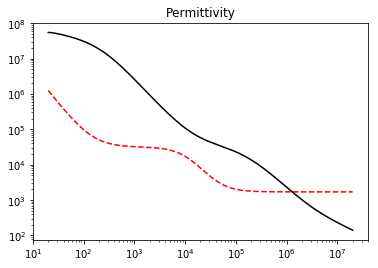

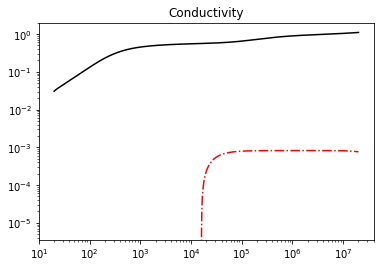

end


In [59]:
#_*_coding:utf-8_*_
# author: Fukun Shi
# 2019/03/24
'''
Third step, use the fitting result with excluding electrode polarization to fit double shell model
'''

####################################definition of MX##########################
Rc = 9e-6 # unit(m). cell radius in buffer, this should be changed according 
#to the chosed cell line
dm = 7e-9    # thinckness of cell membrane m
emed = 80    # permittivity for supernatant, usually fixed as 78
ecp = 100    # permittivity for cytoplasm
p = 0.12     # volumn fraction (*100*100%). p = 3/4*pi*Rc^3*n_cell/Volumn

Rn = 5.1e-6 # 0.84*Rc; % nuclear radius
dn = 40e-9   # thickness of nulear membrane
enp = 120    # Permittivity for nucleoplasm
K = popt[0]
alpha = popt[1]

def double_shell0(w,km,em,kcp,ene,kne,knp,kmed):
    '''
    define the double-shell model
    '''
 
    #alpha = x[8]

    # double cell介电频谱表达式
    v1 = (1-dm/Rc)**3
    v2 = (Rn/(Rc-dm))**3
    v3 =  (1-dn/Rn)**3

    epsi_m = em + km/(w*e0*1j)           # 细胞膜介电谱
    epsi_cp = ecp + kcp/(1j*w*e0)        # 细胞质介电谱
    epsi_ne = ene + kne/(1j*w*e0)        # 细胞核膜
    epsi_np = enp + knp/(1j*w*e0)        # 细胞核质
    epsi_med = emed + kmed/(1j*w*e0)     # 上清液   

    E3 = epsi_np/epsi_ne
    E2 = (epsi_ne/epsi_cp)*(2*(1-v3)+(1+2*v3)*E3)/((2+v3)+(1-v3)*E3) # Eq. 6
    E1 = (epsi_cp/epsi_m)*(2*(1-v2)+(1+2*v2)*E2)/((2+v2)+(1-v2)*E2)  # Eq. 5

    epsi_cell = epsi_m*(2*(1-v1)+(1+2*v1)*E1)/((2+v1)+(1-v1)*E1)     # Eq. 4 细胞的介电谱
    ecell_r = np.real(epsi_cell)
    ecell_i = np.imag(epsi_cell)        # 虚部是负的
    kcell = ecell_i*w*e0

    # 计算悬液介电频谱 permittivity and conductivity of mixture                             
    E0 = epsi_cell/epsi_med
    esus = epsi_med*(2*(1-p)+(1+2*p)*E0)/((2+p)+(1-p)*E0)   # E. 2 悬浮液总体的介电谱        
    esus_r = np.real(esus)
    esus_i = np.imag(esus)
    ksus = esus_i*w*e0                                      # is there a minus?
    # cell suspension admittance spectrum
    Ys = 1j*esus*w*c0 + 1j*w*cf                 
    Zs = 1/Ys
    Zep = K**(-1)*(1j*w)**(-alpha)
    Z = Zs + Zep
    Y_fit = 1/Z
    e_fit_r = Y_fit.imag/(w*a*e0)
    e_fit_i = Y_fit.real/(w*a*e0)
    k_fit = e_fit_i*w*e0
    fit_e = np.concatenate([e_fit_r,k_fit])
    #define the objective function
    #Z_re = np.real(Z)
    #Z_im = np.imag(Z)
    Z = np.hstack([esus_r,ksus])
    return fit_e

#                  km em kcp ene kne knp kmed
x_init = np.array([1e-2,80,2,50,1e-2,2,1])

lb,ub = np.array([1e-10, 1e-1, 1e-2, 1e-2, 1e-10, 1e-2, 1e-2]),np.array([5e1, 
                                                    1e3, 3e5, 2e7, 2e6, 1e10, 1e1])
bounds = ((lb),(ub))

popt0, pcov0 = curve_fit(double_shell0,w,Y_Cole,p0=x_init,maxfev=1200000,ftol=1E-14)  # Y_Cole是上一节定义的，去除了电极极化的介电谱

print('参数拟合值: \n',
      'km:  ','%e'%popt0[0],'\n',
      'em:  ','%e'%popt0[1],'\n',
      'kcp: ','%e'%popt0[2],'\n',
      'ene: ','%e'%popt0[3],'\n',
      'kne: ','%e'%popt0[4],'\n',
      'knp: ','%e'%popt0[5],'\n',
      'kmed:','%e'%popt0[6],'\n',
     )

plt.loglog(f,double_shell0(f,*popt0)[0:point],'r--')
plt.semilogx(f,e_raw[:point],'k')
plt.title('Permittivity')
plt.show()

plt.loglog(f,double_shell0(f,*popt0)[point:],'r-.')
plt.semilogx(f,e_raw[point:],'k')
plt.title('Conductivity')
plt.show()

print('end')